**목차**   
  
1. About Dataset  
  * 데이터 선택 사유   
  * 타겟 선정 및 선택 사유   
  * 데이터 로드 및 확인  
  * feature 설명  
    
2. EDA
3. SentimentIntensityAnalyzer을 통한 데이터 라벨링
4. 모델 생성 및 best model 저장
5. 저장한 데이터 불러오기 및 테스트 하기
6. Knn을 통한 와인 추천 

In [1]:
import warnings
warnings.filterwarnings(action='ignore')


import re
import os
import math
import bert
import datetime
import squarify as sq
import pandas as pd
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from tensorflow import keras
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
from pylab import rcParams
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from colorama import Fore, Back, Style

import seaborn as sns
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.image as image

from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(font_scale=1.2)
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# 1. About Dataset 

## 1-1) 데이터 선정사유 
  


최근 데이터 분석을 통한 고객 맞춤형 서비스가 확대되고 있는 추세입니다.   
이에, 고객들이 각각의 상품에 대해 어떻게 피드백을 하였는지,  
사이트나 앱 내에서 어떤 행동패턴을 보이는지  
또는 전문가들이 해당 상품을 어떻게 평가하였는지를 기반으로   
고객 맞춤서비스가 증가하고 있습니다.

도서추천, 영화추천, 마트 내에서 동시에 구매할 상품들을 묶음 행사 등이 이에 해당됩니다.   
  
이에, 담당자는 와인 추천 시스템을 시현하고자 합니다.   
해당 데이터는 전세계의 와인 품질을 테스트하기 위해 만들어진 데이터입니다..   
해당 데이터에는 소뮬리에의 description이 있으며, 쇼뮬리에의 평가를 감정 분석하여 라벨링을 진행합니다.  
또한, knn으로 유사한 평가를 받은 와인을 추천해주어 와인의 소비를 늘리는 것을 목적으로 추천 시스템을 구현해 보았습니다.   
. 



---

## 1-2) target 선정사유 

  
해당 데이터를 통해 감정분석 및 레이블을 생성하고, 그 레이블을 기준으로 좋은 와인과 나쁜 와인을 분류하는 작업을 진행하고자 한다. 

해당 데이터에서 감정분석이 가능한 이유는 소뮬리에의 개인적인 평가를 description에 기재해 놓은 column이 있다. ( 해당 데이터는 지역, 양조장, 소뮬리에의 평가 점수, 가격등으로 와인의 품질을 분석하기 위한 데이터로 주로 사용되었다.)

---

## 1-3) 데이터 로드 및 확인  

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/daje0601/pandas_study/main/bootcamp_DS/project/section2_porject_210222/winemag-data-130k-v2.csv", index_col=0)

In [3]:
df.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [4]:
# 데이터 shape 확인 
df.shape

(129971, 13)

In [5]:
# 데이터량 확인
df.shape

(129971, 13)

In [6]:
# 데이터 결측치 확인 
df.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [7]:
# df1.info로 확인 결과 대부분 object 데이터 타입임을 확인하였다. 
# check the data info -> This data is almost object types 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [8]:
# object data의 unique를 살펴보았다. 
df.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
taster_twitter_handle,98758,15,@vossroger,25514
region_2,50511,17,Central Coast,11065
taster_name,103727,19,Roger Voss,25514
country,129908,43,US,54504
province,129908,425,California,36247
variety,129970,707,Pinot Noir,13272
region_1,108724,1229,Napa Valley,4480
winery,129971,16757,Wines & Winemakers,222
designation,92506,37979,Reserve,2009
title,129971,118840,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,11


## 1-4) feature 설명 
  
'country' - 어느나라에서 생산되었는지  
'description' - 와인 시음 후 와인에 대한 평가 및 설명   
'designation' - 양조장이 있는 포도원   
'points' - 시음 후 와인 점수   
'price' - 와인의 가격 ( "our target" )  
'province' - 와인 제작 시, 사용되는 포도의 출처   
'region_1' - 포도가 자라는 지역 
'region_2' - 포도가 자라는 지역을 상세하게 기재한 feature
'taster_name' - 시음한 사람     
'taster_twitter_handle' 시음한 사람의 트위터   
'title' - 와인명  
'variety' - 와인을 만들때 혼합된 포도  
'winery' - 양조장명  

### **☆ 지금까지 insight ☆**  
 1. description을 감정분석 및 자연어처리 후 딥러닝으로 분석하여 좋은 와인을 분류한 후 knn으로 추천해주는 시스템을 만들어보고자 한다.   
       
 2. region_1과 region_2도 동일한 정보를 나타내며, title에 region정보가 있는 것을 확인할 수 있었다.  
    -> 결측치는 이로 대체 예정 
      
 3. taster_name와 taster_twitter_handle도 taster에 대한 동일한 정보를 제공해주고 있다.  
    -> 확인 후 합칠 수 있는 것들은 혼합할 예정 
      
 4. title, variety, winery 등은 결측치가 거의 없다. 이에, 해당 데이터를 활용하여 결측치를 채울 수 있는 것들은 채울 예정
   
 5. designation과 winery를 동일하게 양조장에 대한 정보를 나타내고 있다.  
     -> 확인 후 합칠 수 있는 것들은 혼합할 예정     
   
 6. 또한, 너무 unique가 높기 때문에 각 feature별로 count하여 count된 만큼 페센트로 가중치를 주고자 한다.  


### ☆ 나라별 용어 따른 숙성 정도 차이 ☆

7. 스페인, 이탈리아 ( 법적 필수 준수사항 )


 |등급|내용|
 |----|-----|
 |joven|전혀 숙성을 시키지 않고 바로 출시된 와인|
 |crianza|최소 24개월이상 오크 및 병에 담아 숙성 후 출시된 와인|
 |reserva|최소 36개월이상 오크 및 병에 담아 숙성 후 출시된 와인|
 |gran reserva|최소 60개월이상 오크 및 병에 담아 숙성 후 출시된 와인|

8. 그외나라(미국, 칠레, 호주, 뉴질랜드 등)   
 -. 별다른 규정 없이 바로 taster에게 좋은 평가를 받으면 reserva라는 표기 가능   

9. 기타(혼용되는 용어)  
 -. reserva는 나라에 따라서 riserva, reserve 등으로 혼용되어 사용된다고 한다.  
 -. ["À", "A"],["Á", "A"],["Â", "A"],["Ã", "A"],["Ä", "A"],["Ä", "A"],["Å", "A"]  
 -. ,["à", "a"],["á", "a"],["â", "a"],["ã", "a"],["ä", "a"],["ä", "a"],["å", "a"]  
 -. ,["È", "E"],["É", "E"],["Ê", "E"],["Ë", "E"],["Ë", "E"]  
 -. ,["è", "e"],["é", "e"],["ê", "e"],["ë", "e"],["ë", "e"]  
 -. ,["Æ", "AE"],["æ", "ae"],["Ç", "C"],["ç", "c"]  
 -. ,["Ì", "I"],["Í", "I"],["Î", "I"],["Ï", "I"],["Ï", "I"]  
 -. ,["ì", "i"],["í", "i"],["î", "i"],["ï", "i"],["ï", "i"]  
 -. ,["Ð", "D"],["ð", "d"],["Ñ", "N"],["ñ", "n"]  
 -. ,["Ò", "O"],["Ó", "O"],["Ô", "O"],["Õ", "O"],["Ö", "O"],["Ö", "O"],["Œ", "OE"]   
 -. ,["ò", "o"],["ó", "o"],["ô", "o"],["õ", "o"],["ö", "o"],["ö", "o"],["œ", "oe"]  
 -. ,["Ù", "U"],["Ú", "U"],["Û", "U"],["Ü", "U"],["Ü", "U"]  
 -. ,["ù", "u"],["ú", "u"],["û", "u"],["ü", "u"],["ü", "u"]  
 -. ,["Ý", "Y"],["Ÿ", "Y"],["Ÿ", "Y"]  
 -. ,["ý", "y"],["ÿ", "y"],["ÿ", "y"]  
 -. ,["Þ", "P"],["þ", "p"],["ß", "s"]["¡", "!"]["¿", "?"]  
  -> 위 용어를 모두 분석한 결과, 부분적으로만 대문자로 시작되는 글자는 없었으며,    
  -> 제품의 발음을 위해 France 등 일부 유럽국가에서만 특수문자로 기재가 되어 있음을 확인하였다.   
  -> 이에, 카테고리티를 줄이기 위해서 이를 통일하는 작업이 필요하다가 생각된다. 

10. 출처   
 -. 와인등급 :https://www.wine21.com/11_news/news_view.html?Idx=17111  
 -. 와인등급 : https://m.blog.naver.com/interkj87/220699483883  
 -. 와인등급 : https://www.decantalo.com/en/blog/winemaking/classifying-wines-by-their-age-crianza-reserva-gran-reserva/  
 -. 유럽(문자) 표기법:http://help.hancom.com/hoffice/multi/ko_kr/hwp/insert/europe.htm
※ 모든 title에 해당 정보가 기재되어 있음

# 2. 전처리

In [9]:
# 데이터 정보확인을 위한 함수 생성 ( Missing, 'Missing percent, Uniques)
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Uniques'] = df.nunique().values
    summary['Missing'] = df.isnull().sum().values    
    summary['Missing percent'] = summary['Missing']/df.shape[0]
    return summary

In [10]:
resumetable(df).sort_values(by=['Missing percent'],ascending = False)

Dataset Shape: (129971, 13)


,Name,dtypes,Uniques,Missing,Missing percent
7,region_2,object,17,79460,0.611367
2,designation,object,37979,37465,0.288257
9,taster_twitter_handle,object,15,31213,0.240154
8,taster_name,object,19,26244,0.201922
6,region_1,object,1229,21247,0.163475
4,price,float64,390,8996,0.069215
0,country,object,43,63,0.000485
5,province,object,425,63,0.000485
11,variety,object,707,1,0.000008
1,description,object,119955,0,0.000000


In [11]:
# 수치형 데이터 확인 
df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [12]:
# 결측치 처리 
for col in ('region_2', 'designation', 'taster_twitter_handle', 'taster_name', 'region_1'):
    df[col]=df[col].fillna('Unknown') # 알 수 없는 값들은 Unknown 처리 
df['province'] = df['province'].fillna(df['province'].mode()) # 최빈값으로 처리
df['price'] = df['price'].fillna(df['price'].mean())

In [13]:
# 결측치 확인 및 제거
print(df.isnull().sum())
df = df.dropna()
print(df.isnull().sum())

country                  63
description               0
designation               0
points                    0
price                     0
province                 63
region_1                  0
region_2                  0
taster_name               0
taster_twitter_handle     0
title                     0
variety                   1
winery                    0
dtype: int64
country                  0
description              0
designation              0
points                   0
price                    0
province                 0
region_1                 0
region_2                 0
taster_name              0
taster_twitter_handle    0
title                    0
variety                  0
winery                   0
dtype: int64


In [14]:
# 데이터 중복확인 
df[df.duplicated('description',keep=False)].sort_values('description').head(4)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
67614,US,"100% Malbec, it's redolent with dark plums, wi...",Unknown,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
46540,US,"100% Malbec, it's redolent with dark plums, wi...",Unknown,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
119702,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
72181,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew


In [15]:
# 중복된 데이터가 확인되어 삭제 
df.drop_duplicates(('description', 'title'), inplace=True)
df[pd.notnull(df.price)]
df.shape

(119928, 13)

데이터 결측치 및 중복된 데이터를 삭제한 후 데이터의 수 확인결과 129971-119928 = 10043개의 데이터가 삭제되었다.   
그러나 해당 데이터를 drop하고도 많은 양의 데이터를 보유하고 있으므로 실험을 진행하는데는 큰 문제가 없을 것으로 사료된다.

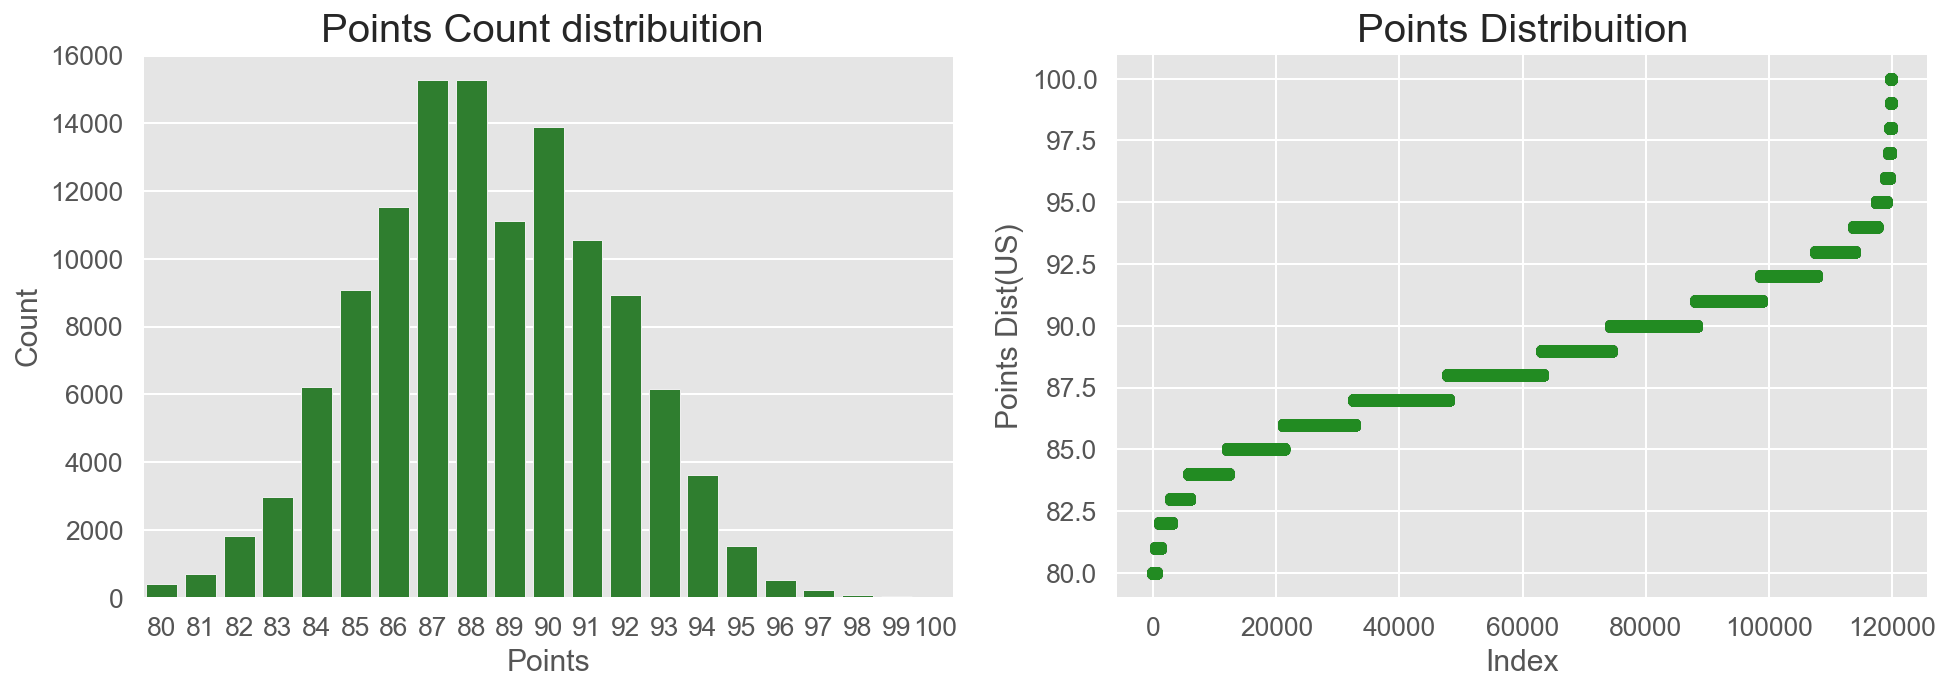

In [16]:
# point와 price에 대한 데이터 분포현황 확인 
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
g = sns.countplot(x='points', data=df, color='forestgreen')
g.set_title("Points Count distribuition ", fontsize=20)
g.set_xlabel("Points", fontsize=15) 
g.set_ylabel("Count", fontsize=15) 

plt.subplot(1,2,2) 
plt.scatter(range(df.shape[0]), np.sort(df.points.values), color='forestgreen') 
plt.xlabel('Index', fontsize=15)
plt.ylabel('Points Dist(US)', fontsize=15)  
plt.title("Points Distribuition", fontsize=20)

plt.show() #rendering the graphs

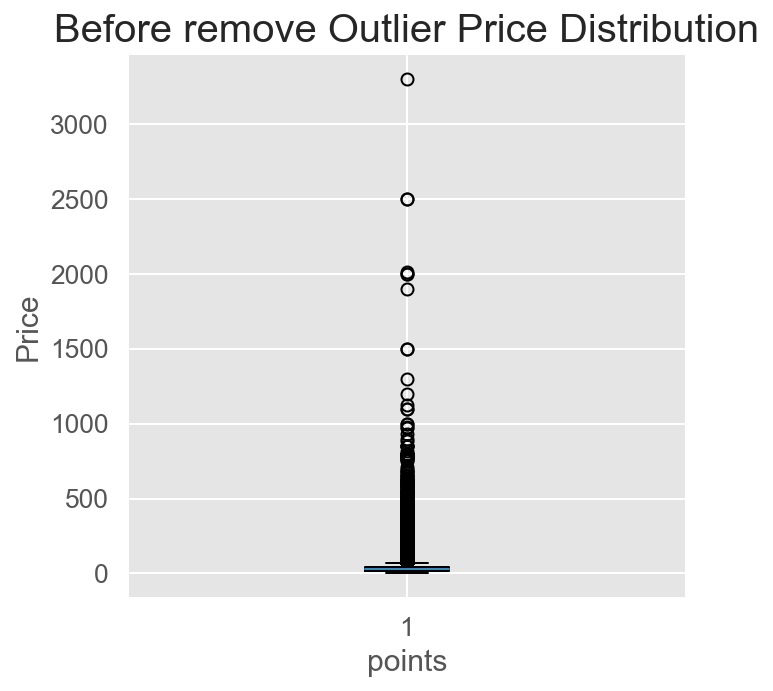

In [17]:
plt.figure(figsize=(5,5))
plt.boxplot(df['price'])

plt.title("Before remove Outlier Price Distribution", fontsize=20) 
plt.xlabel("points", fontsize=15)
plt.ylabel("Price", fontsize=15)

plt.show()

In [18]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [19]:
# 함수 사용해서 price column 이상치 값 삭제
outlier_idx = get_outlier(df=df, column='price', weight=1.5)
df.drop(outlier_idx, axis=0, inplace=True)

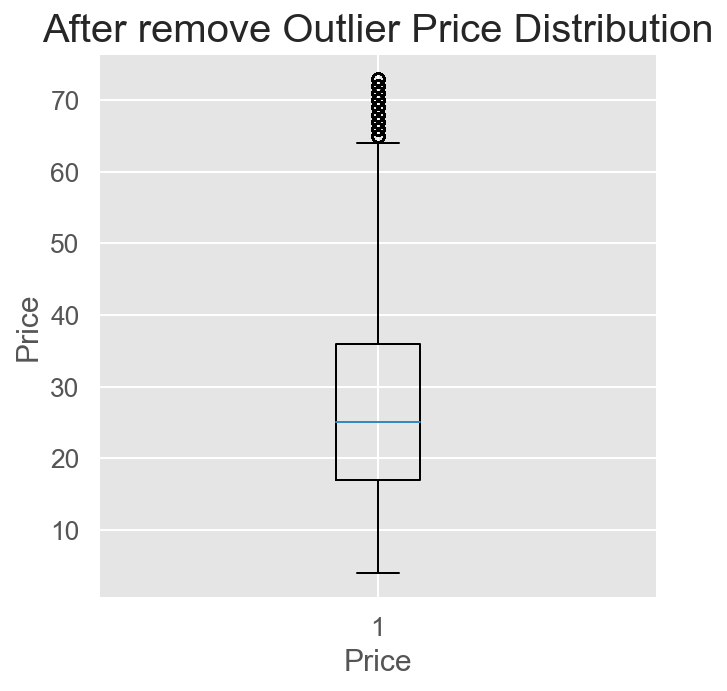

In [20]:
plt.figure(figsize=(5,5))
plt.boxplot(df['price'])

plt.title("After remove Outlier Price Distribution", fontsize=20)  
plt.xlabel("Price", fontsize=15)
plt.ylabel("Price", fontsize=15)

plt.show()

In [21]:
df.shape

(111370, 13)

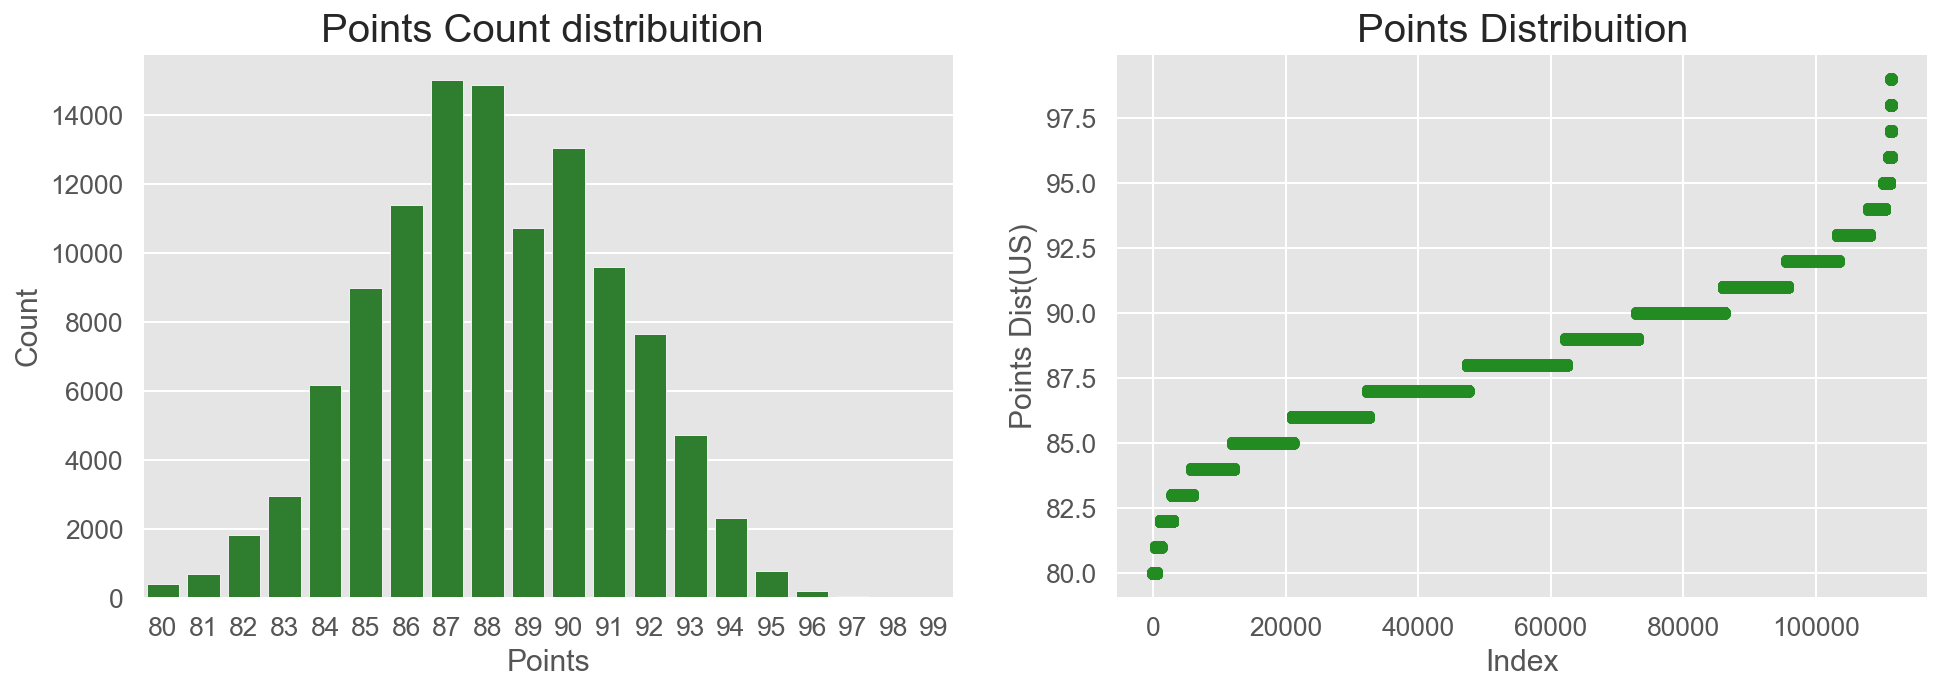

In [22]:
# define the size of figures that I will build
plt.figure(figsize=(16,5))

plt.subplot(1,2,1) # this will create a grid of 1 row and 2 columns; this is the first graphic
g = sns.countplot(x='points', data=df, color='forestgreen') # seting the seaborn countplot to known the points distribuition
g.set_title("Points Count distribuition ", fontsize=20) # seting title and size of font
g.set_xlabel("Points", fontsize=15) # seting xlabel and size of font
g.set_ylabel("Count", fontsize=15) # seting ylabel and size of font

plt.subplot(1,2,2)  # this will set the second graphic of our grid
plt.scatter(range(df.shape[0]), np.sort(df.points.values), color='forestgreen') # creating a cumulative distribution
plt.xlabel('Index', fontsize=15)  # seting xlabel and size of font
plt.ylabel('Points Dist(US)', fontsize=15)  # seting ylabel and size of font
plt.title("Points Distribuition", fontsize=20) # seting title and size of font

plt.show() #rendering the graphs

In [23]:
df.describe()

,points,price
count,111370.000000,111370.000000
mean,88.164084,28.892244
std,2.943215,14.753215
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,90.000000,36.000000
max,99.000000,73.000000


In [24]:
w = df.groupby(['country','points'])['price'].agg(['count','min','max','mean']).sort_values(by='mean',ascending=False)[:10]
w.reset_index(inplace=True)
w

,country,points,count,min,max,mean
0,Chile,95,1,70.000000,70.0,70.000000
1,Italy,98,2,60.000000,70.0,65.000000
2,Australia,95,5,60.000000,70.0,63.000000
3,US,98,6,50.000000,70.0,62.333333
4,US,97,25,35.000000,70.0,60.400000
5,England,95,2,50.000000,70.0,60.000000
6,Spain,95,6,50.000000,70.0,60.000000
7,Romania,90,1,58.000000,58.0,58.000000
8,Mexico,90,1,56.000000,56.0,56.000000
9,Italy,97,5,35.363389,70.0,55.672678


In [25]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [26]:
data = df['country'].replace("US", "United States").value_counts()
iplot([go.Choropleth(
    locationmode='country names',
    locations=data.index.values,
    text=data.index,
    z=data.values,
    colorscale='portland'
)])

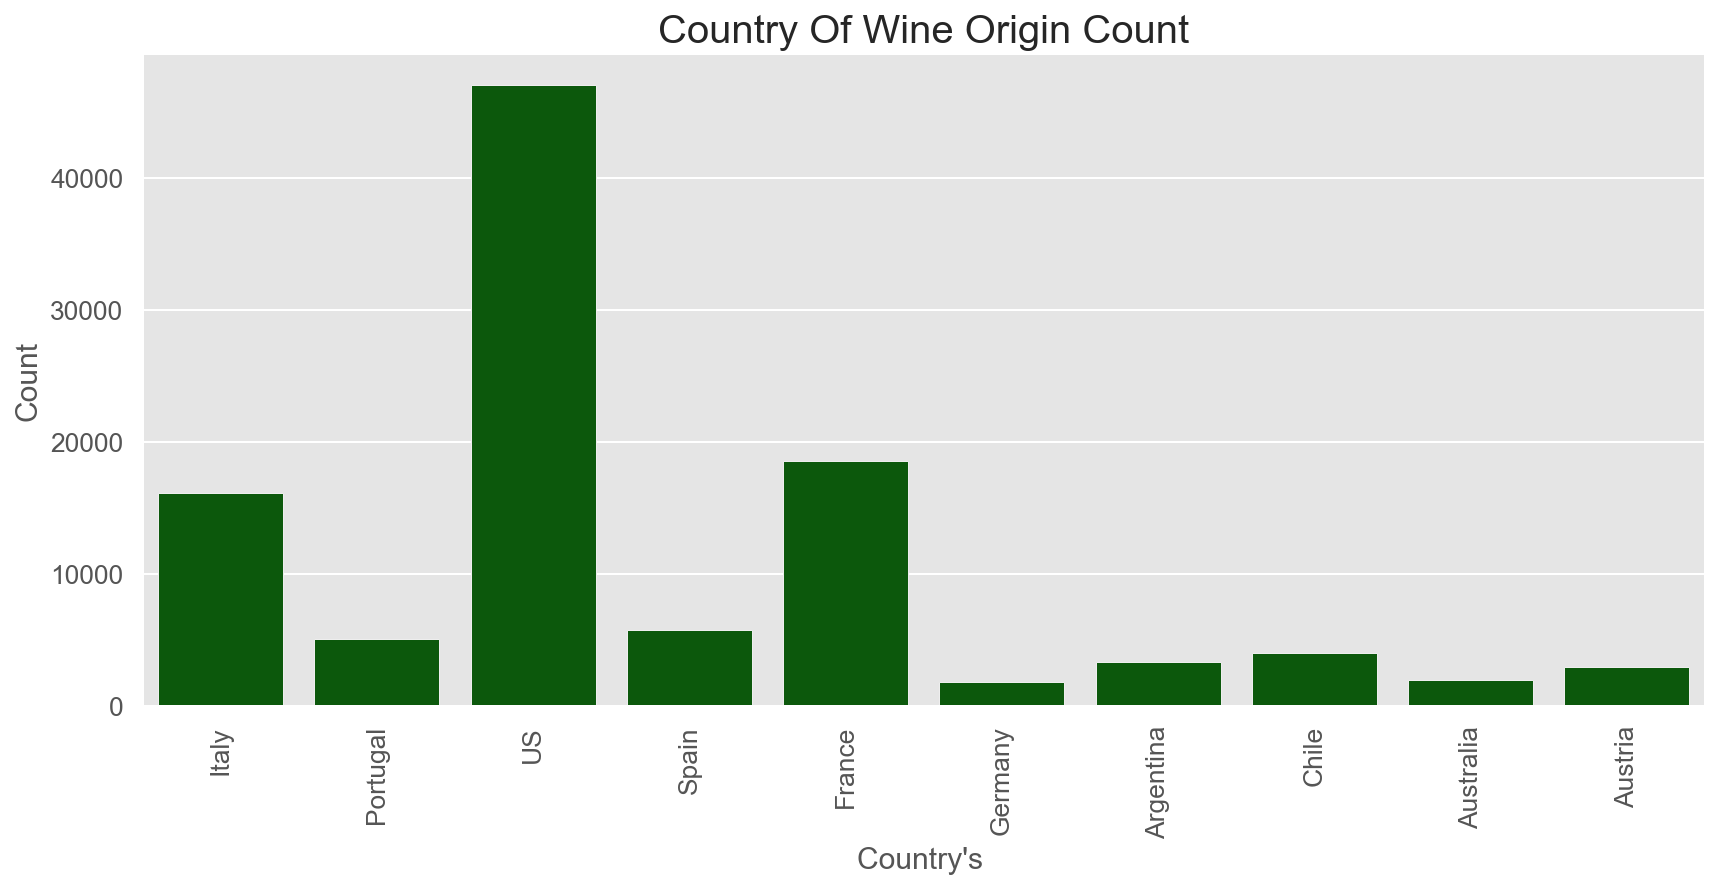

In [27]:
# Country Feature

plt.figure(figsize=(14,6))

country = df.country.value_counts(ascending=False)[:10]
g = sns.countplot(x='country', 
                  data=df[df.country.isin(country.index.values)],
                 color='darkgreen')
g.set_title("Country Of Wine Origin Count", fontsize=20)
g.set_xlabel("Country's ", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.show()


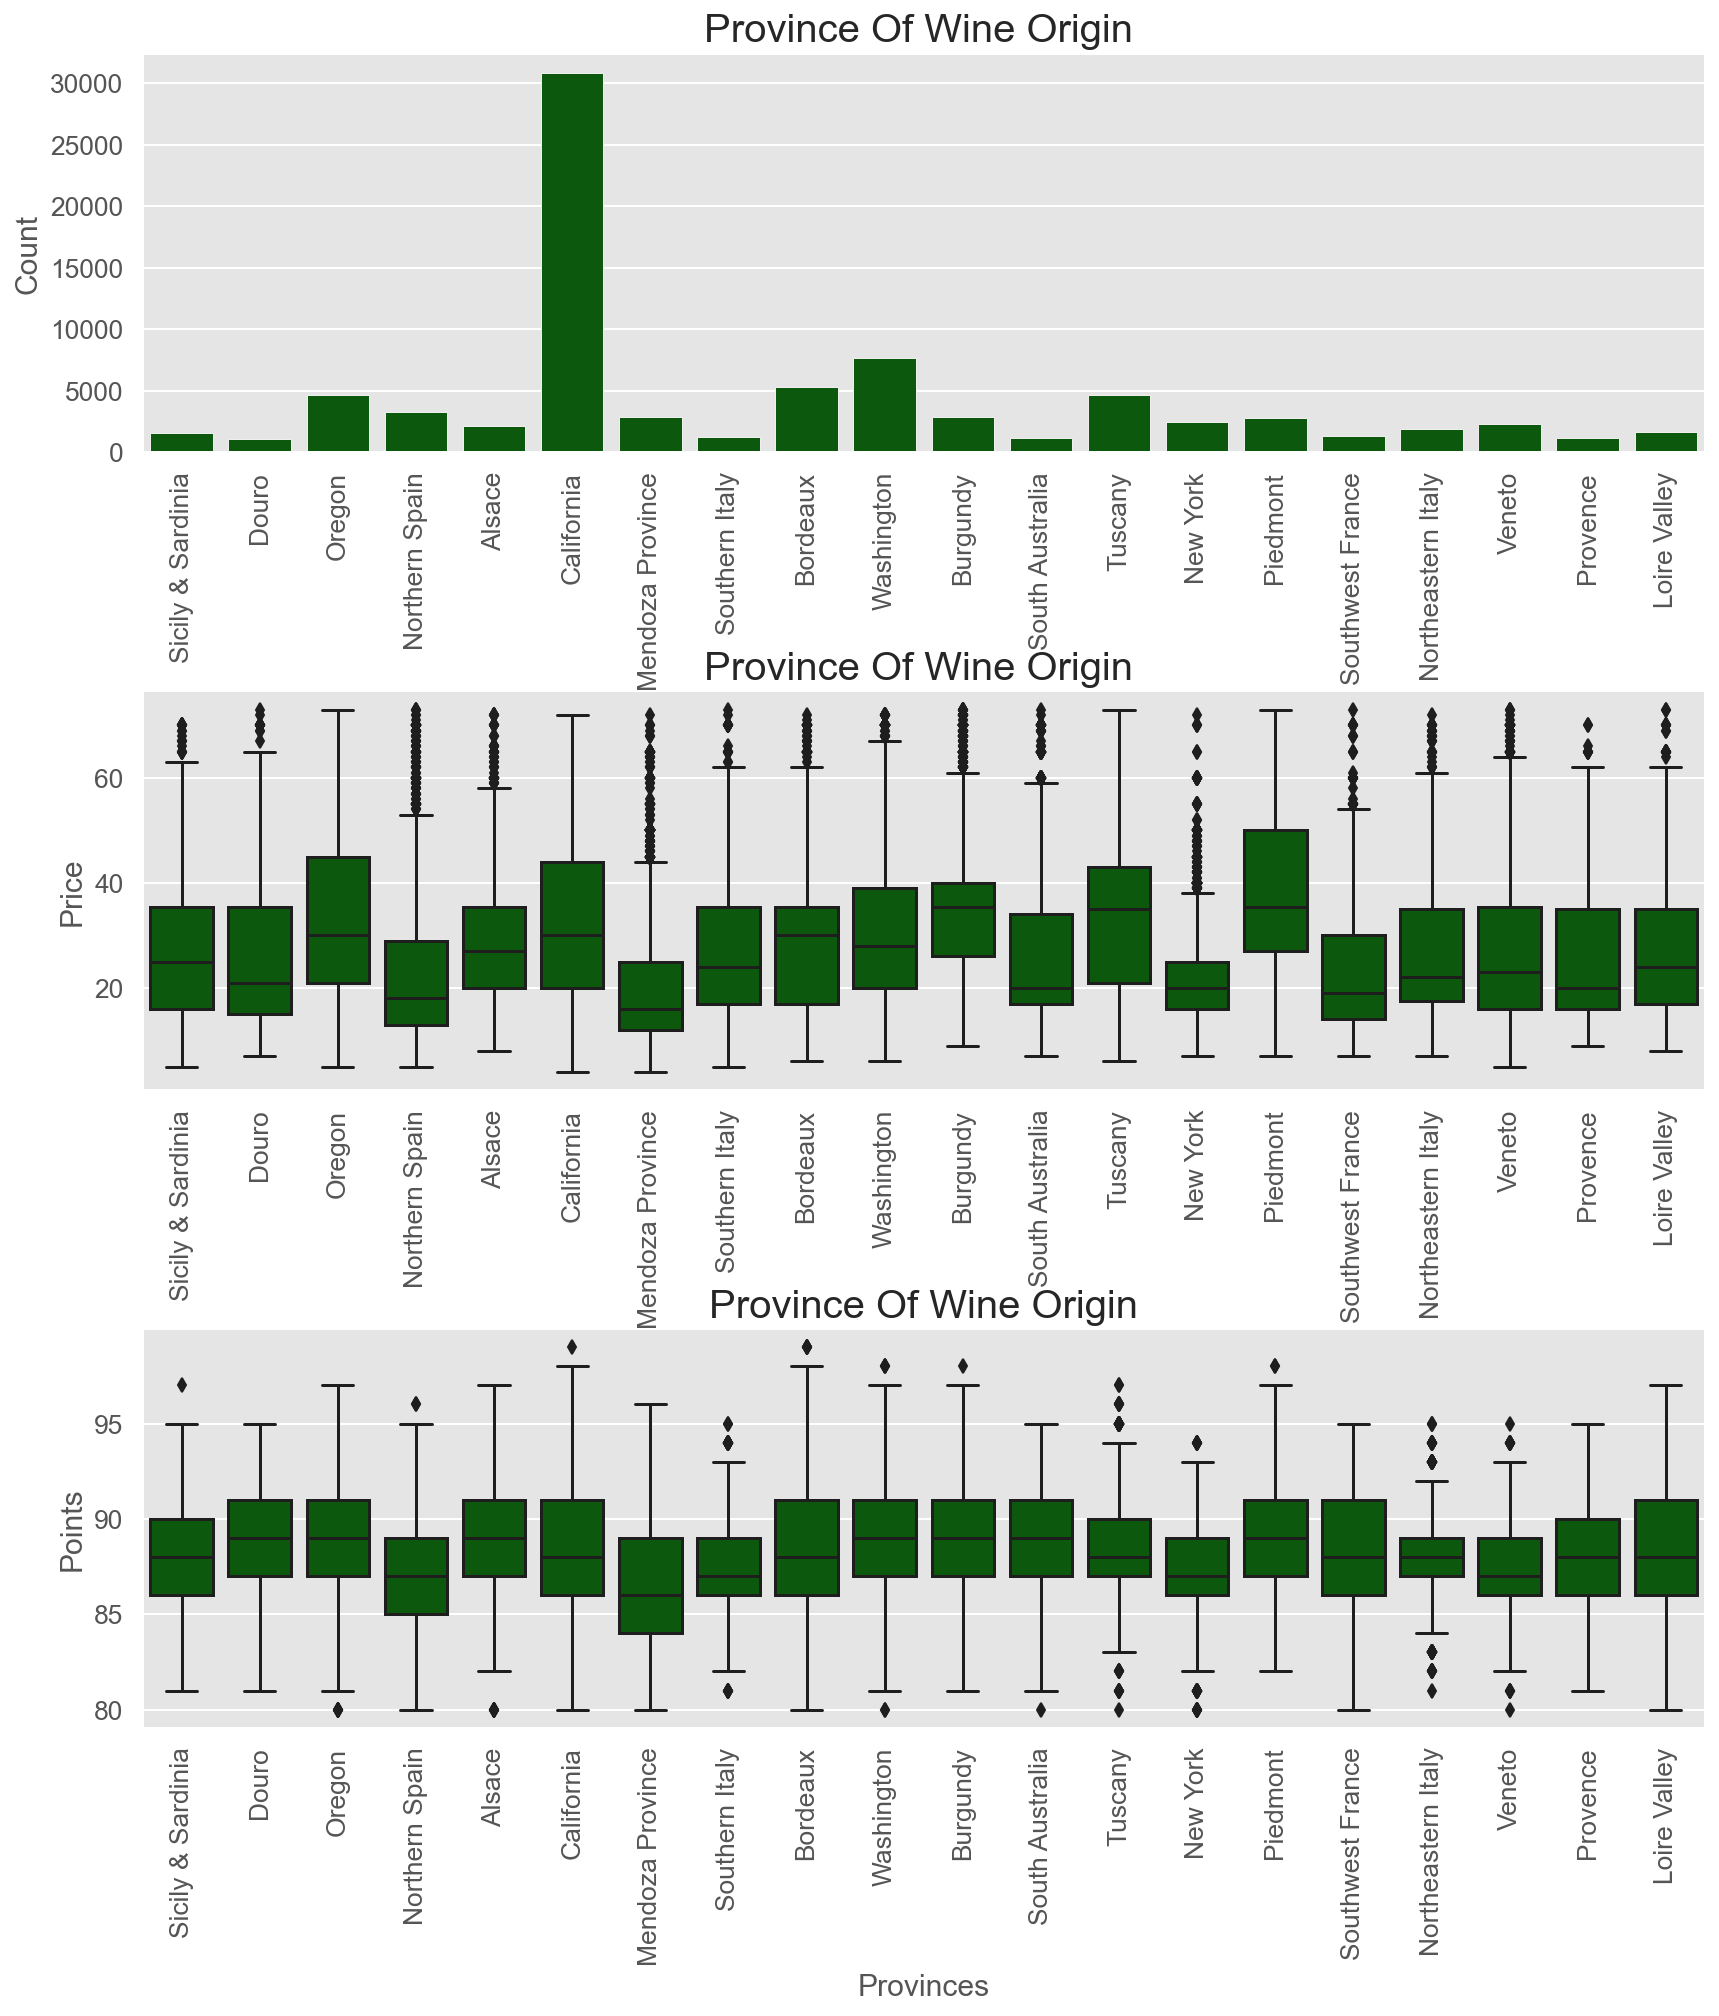

In [28]:
plt.figure(figsize=(14,15))

provinces = df['province'].value_counts()[:20]

plt.subplot(3,1,1)
g = sns.countplot(x='province', 
                  data=df.loc[(df.province.isin(provinces.index.values))], 
                  color='darkgreen')
g.set_title("Province Of Wine Origin ", fontsize=20)
g.set_xlabel("Provinces", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(3,1,2)
g1 = sns.boxplot(y='price', x='province',
                  data=df.loc[(df.province.isin(provinces.index.values))], 
                  color='darkgreen')
g1.set_title("Province Of Wine Origin ", fontsize=20)
g1.set_xlabel("Province", fontsize=15)
g1.set_ylabel("Price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=90)

plt.subplot(3,1,3)
g2 = sns.boxplot(y='points', x='province',
                  data=df.loc[(df.province.isin(provinces.index.values))], 
                  color='darkgreen')
g2.set_title("Province Of Wine Origin", fontsize=20)
g2.set_xlabel("Provinces", fontsize=15)
g2.set_ylabel("Points", fontsize=15)
g2.set_xticklabels(g2.get_xticklabels(),rotation=90)

plt.subplots_adjust(hspace = 0.6,top = 0.9)

plt.show()

(-0.5, 999.5, 799.5, -0.5)

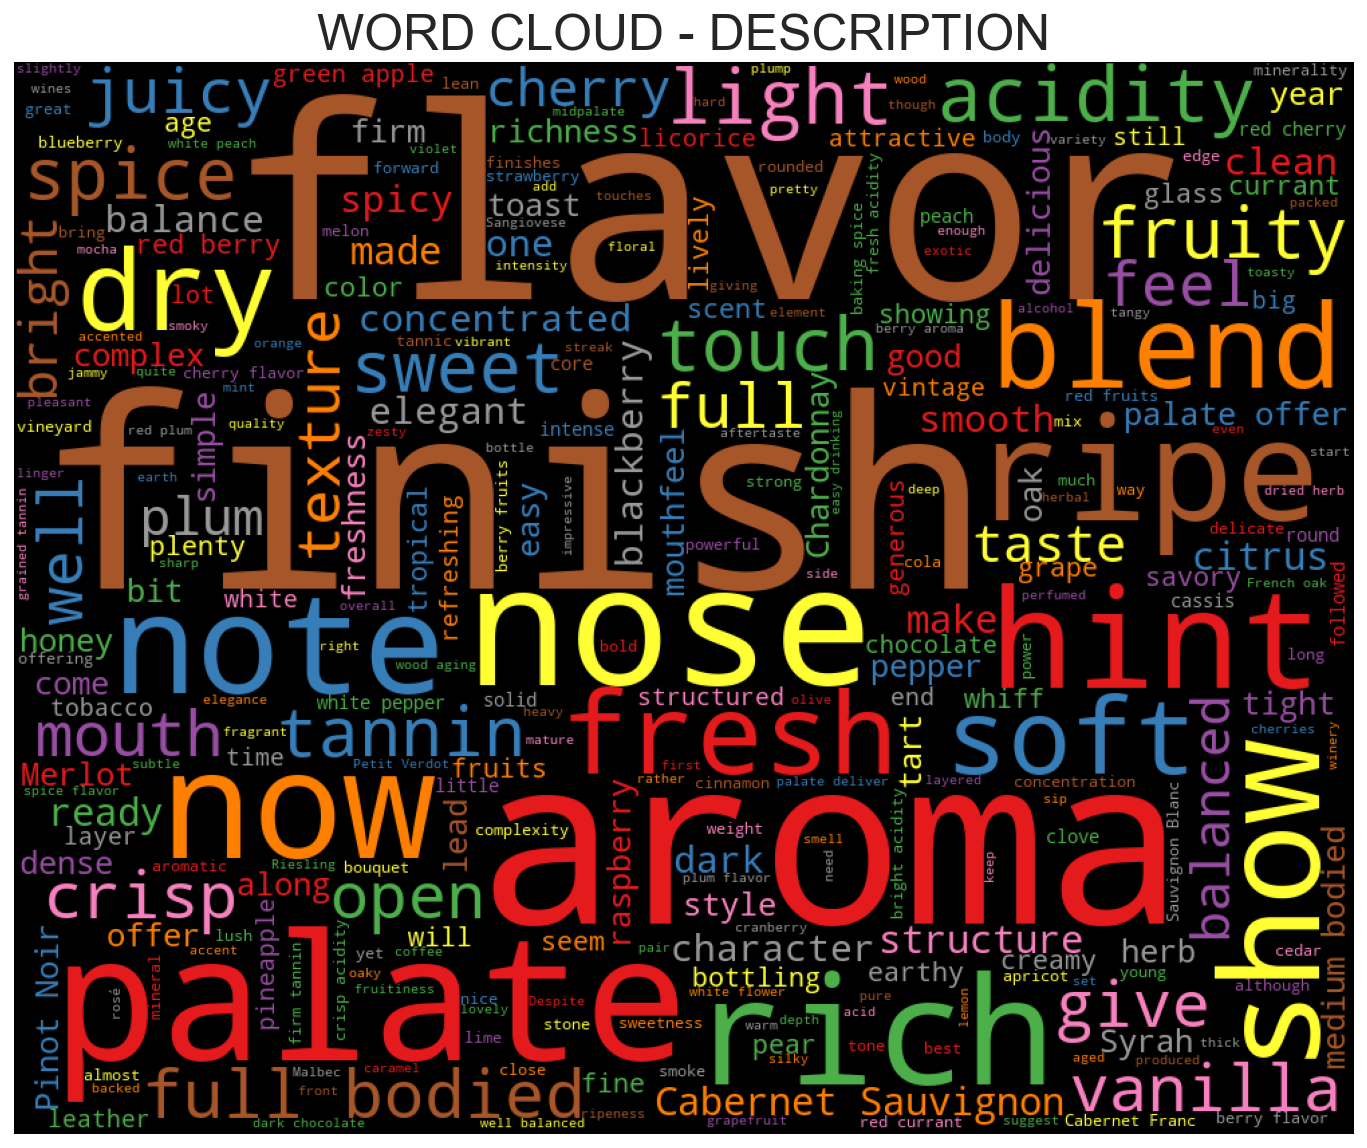

In [29]:
stopwords = set(STOPWORDS)
newStopWords = ['fruit', "Drink", "black", 'wine', 'drink']
stopwords.update(newStopWords)
wordcloud = WordCloud(
    stopwords=stopwords,
    colormap='Set1',
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df['description'].astype(str)))
print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - DESCRIPTION",fontsize=25)
plt.axis('off')

(-0.5, 999.5, 799.5, -0.5)

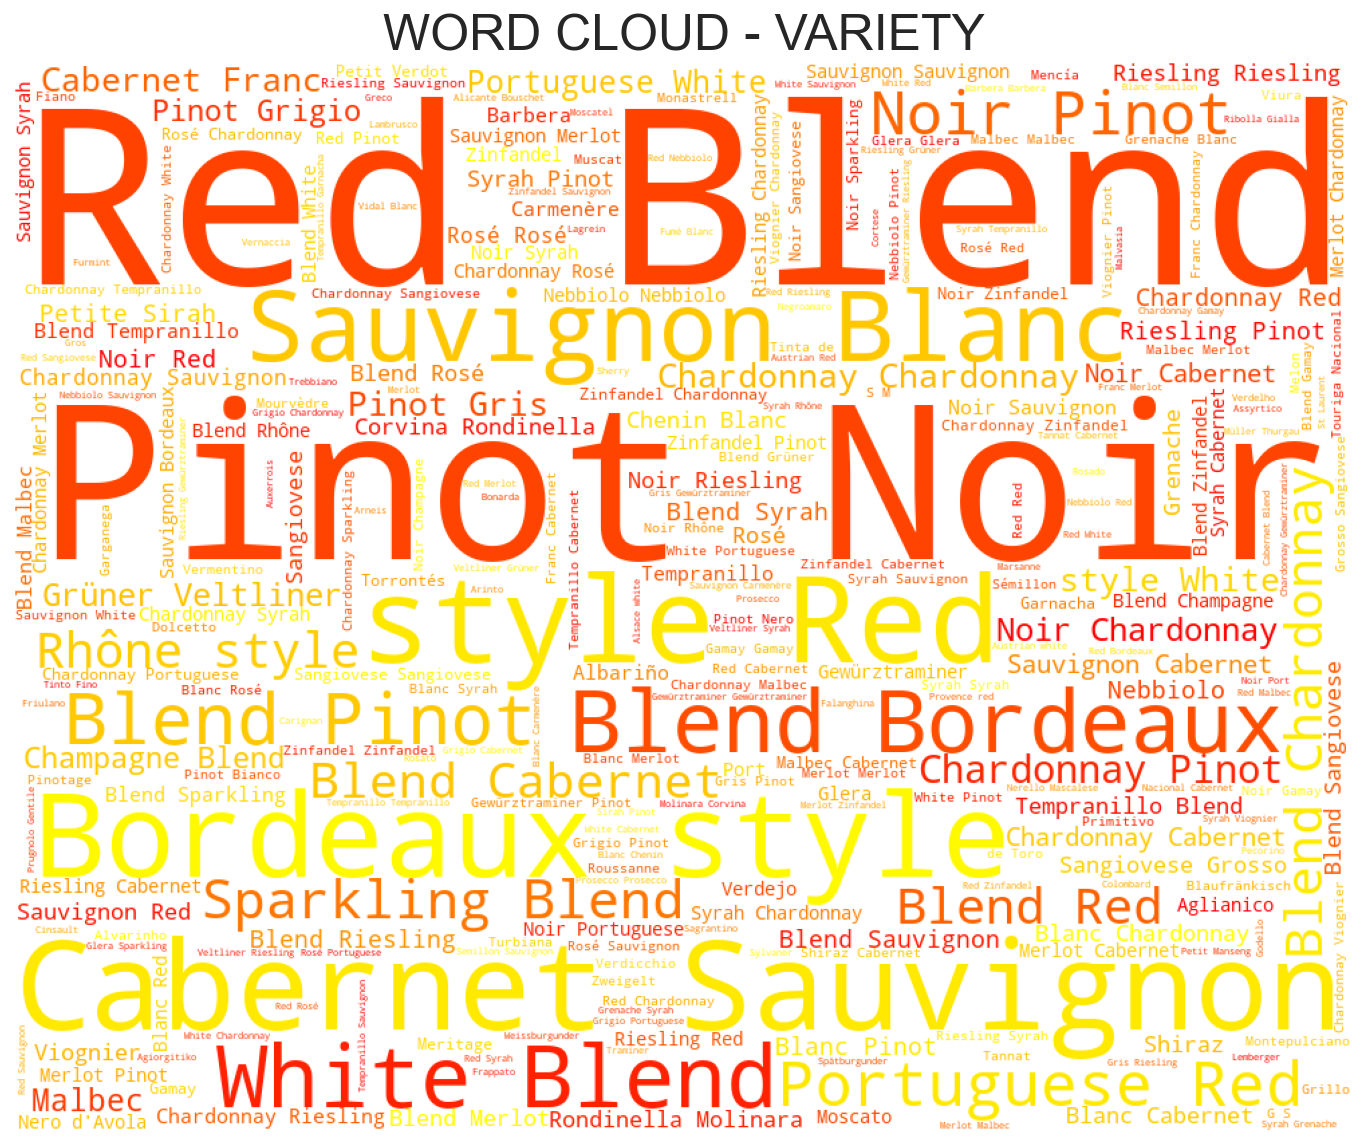

In [30]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    colormap='autumn_r',
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df['variety'].astype(str)))
print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - VARIETY",fontsize=25)
plt.axis('off')

# 3. SentimentIntensityAnalyzer을 통한 데이터 라벨링

교육 및 시연 목적으로 NLTK 기능 및 분류기를 사용하여 감정 분석 작업을 도구로써
데이터를 -1에서 1사이로 분류하는 작업을 진행하게 됩니다. 
긍정, 중립, 부정에 대한 것을 각각 계산한 뒤 이를 극점을 합산하게 됩니다. 
이에, 따라 라벨을을 해주는 작업을 진행하였습니다. 

In [31]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

SIA = SentimentIntensityAnalyzer()

# Applying Model, Variable Creation
sentiment = df.copy()
sentiment['polarity_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['compound'])
sentiment['neutral_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['neu'])
sentiment['negative_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['neg'])
sentiment['positive_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['pos'])

sentiment['sentiment']= np.nan
sentiment.loc[sentiment.polarity_score>0.5,'sentiment']=1
sentiment.loc[sentiment.polarity_score<=0.5,'sentiment']=0
# 원래는 중립값도 있으나 해당 분석에서는 중립값이 별도로 필요하지 않아 0으로 합산하여 분석을 진행하였습니다.
sentiment["sentiment"].value_counts()

1.0    66443
0.0    44927
Name: sentiment, dtype: int64

In [33]:
sentiment.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,polarity_score,neutral_score,negative_score,positive_score,sentiment
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Unknown,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,0.1531,0.935,0.0,0.065,0.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,Unknown,Unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,0.6486,0.868,0.0,0.132,1.0


In [34]:
df_label = sentiment[["description", "sentiment"]]
df_label.head(2)

,description,sentiment
0,"Aromas include tropical fruit, broom, brimston...",0.0
1,"This is ripe and fruity, a wine that is smooth...",1.0


In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()

In [36]:
import spacy
from spacy.tokenizer import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nlp = spacy.load('en_core_web_lg')

# 정규화과정 
def normalize_text(text):
    tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
    tm3 = re.sub('<[^>]+>©', '', tm1, flags=re.DOTALL)
    return tm3.replace("\n", "")

In [37]:
df_label.head(2)

,description,sentiment
0,"Aromas include tropical fruit, broom, brimston...",0.0
1,"This is ripe and fruity, a wine that is smooth...",1.0


In [38]:
# 소문자, 특수문자 제거 과정 
def token_preprocessing(text):
    text = str(text).lower()
    regex = r'[^a-zA-Z0-9 ]'
    text = re.sub(regex, '', text)
    return text

df_label['description'] = df_label['description'].apply(normalize_text)
df_label['description'] = df_label['description'].apply(token_preprocessing)

In [39]:
df_label.head(2)

,description,sentiment
0,aromas include tropical fruit broom brimstone ...,0.0
1,this is ripe and fruity a wine that is smooth ...,1.0


In [40]:
# 토큰화 과정 
tokens = []
for doc in nlp.pipe(df_label['description']):
    doc_tokens = [token.lemma_ for token in doc if (token.is_stop == False) & (token.is_punct == False) & (token.is_alpha)]
    tokens.append(doc_tokens)
    
df_label['tokens'] = tokens

# 토큰화 확인 
df_label.head()

,description,sentiment,tokens
0,aromas include tropical fruit broom brimstone ...,0.0,"[aroma, include, tropical, fruit, broom, brims..."
1,this is ripe and fruity a wine that is smooth ...,1.0,"[ripe, fruity, wine, smooth, structure, firm, ..."
2,tart and snappy the flavors of lime flesh and ...,0.0,"[tart, snappy, flavor, lime, flesh, rind, domi..."
3,pineapple rind lemon pith and orange blossom s...,0.0,"[pineapple, rind, lemon, pith, orange, blossom..."
4,much like the regular bottling from 2012 this ...,1.0,"[like, regular, bottle, come, rough, tannic, r..."


In [41]:
df_tokens = df_label[["tokens", "sentiment"]]
df_tokens.head(2)

,tokens,sentiment
0,"[aroma, include, tropical, fruit, broom, brims...",0.0
1,"[ripe, fruity, wine, smooth, structure, firm, ...",1.0


In [42]:
# 데이터 분리 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_label.tokens, df_label.sentiment, test_size = 0.2, random_state = 42)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89096,), (22274,), (89096,), (22274,))

In [44]:
# 단어 인덱싱화 
maxlen = 80
batch_size = 32

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [45]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [46]:
# 데이터 크기 조절(패딩작업)
Max_length = 70

train_input = pad_sequences(X_train, maxlen=Max_length, padding='post')
train_labels = y_train

test_input = pad_sequences(X_test, maxlen=Max_length, padding='post')
test_labels = y_test

# 모델 생성 및 best model 저장 

In [47]:
model = Sequential()
model.add(Embedding(89096, 8, input_length=Max_length))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


# 학습시킨 데이터를 저장시키기 위한 코드입니다. 
checkpoint_filepath = "Project_AI_01_강다솔.hdf5"

# overfitting을 방지하기 위해서 학습 중 early stop을 수행하기 위한 코드입니다.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기 위한 코드입니다.
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)


history = model.fit(train_input, train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop, save_best])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 8)             712768    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5248      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 718,049
Trainable params: 718,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2228/2228 [==============================] - 41s 17ms/step - loss: 0.6013 - acc: 0.6631 - val_loss: 0.3021 - val_acc: 0.8746

Epoch 00001: val_loss improved from inf to 0.30206, saving model to Project_AI_01_강다솔.hdf5
Epoch 2/50
2228/2228 [==============================] - 37s 16ms/step - loss: 0.2955 - acc: 0.8811 - val_loss: 0.3077 - val_acc: 0.8810

Epoch 00002: va

# 5. 저장한 데이터 불러오기 및 테스트 하기

In [48]:
model.load_weights(checkpoint_filepath)

In [49]:
# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드

model.predict(test_input[0:2])
test_loss, test_acc = model.evaluate(test_input,  test_labels, verbose=2)

697/697 - 2s - loss: 0.2478 - acc: 0.9016


# 6. Knn을 통한 와인 추천 

In [50]:
sentiment_knn = sentiment[sentiment["sentiment"]==1]
sentiment_knn.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,polarity_score,neutral_score,negative_score,positive_score,sentiment
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Unknown,Unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,0.6486,0.868,0.0,0.132,1.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,0.8176,0.805,0.0,0.195,1.0


In [51]:
sentiment_knn.shape

(66443, 18)

In [52]:
from sklearn.neighbors import NearestNeighbors # KNN Clustering 
from scipy.sparse import csr_matrix # Compressed Sparse Row matrix
from sklearn.decomposition import TruncatedSVD # Dimensional Reduction

In [53]:
# Lets choice rating of wine is points, title as user_id, and variety,
col = ['province','variety','points']

wine1 = sentiment_knn[col]
wine1 = wine1.dropna(axis=0)
wine1 = wine1.drop_duplicates(['province','variety'])
wine1 = wine1[wine1['points'] > 90]

wine_pivot = wine1.pivot(index= 'variety',columns='province',values='points').fillna(0)
wine_pivot_matrix = csr_matrix(wine_pivot)

In [54]:
wine_pivot_matrix

<209x163 sparse matrix of type '<class 'numpy.float64'>'
	with 501 stored elements in Compressed Sparse Row format>

In [55]:
knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_pivot_matrix)

In [56]:
for n in range(5):
    query_index = np.random.choice(wine_pivot.shape[0])

    distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1), n_neighbors=6)
    for i in range(0, len(distance.flatten())):
        if  i == 0:
            print('Recmmendation for ## {0} ##:'.format(wine_pivot.index[query_index]))
        else:
            print('{0}: {1}'.format(i,wine_pivot.index[indice.flatten()[i]]))
    print('\n')

Recmmendation for ## Mourvèdre-Syrah ##:
1: Tempranillo
2: Cabernet Sauvignon-Merlot-Shiraz
3: Montepulciano
4: Shiraz-Cabernet Sauvignon
5: Roussanne


Recmmendation for ## Teroldego ##:
1: Pignolo
2: Kerner
3: Verduzzo
4: Picolit
5: Teroldego


Recmmendation for ## Meseguera ##:
1: Sparkling Blend
2: Roussanne-Grenache Blanc
3: Roussanne
4: Roussanne-Marsanne
5: Rosé


Recmmendation for ## Barbera ##:
1: Nebbiolo
2: Roviello
3: Roussanne-Grenache Blanc
4: Roussanne-Viognier
5: Roussanne-Marsanne


Recmmendation for ## Muscat Canelli ##:
1: Muscat Canelli
2: Gewürztraminer-Riesling
3: Cabernet Franc-Merlot
4: Rhône-style White Blend
5: Syrah-Grenache




In [57]:
wine_pivot.index

Index(['Abouriou', 'Aglianico', 'Alfrocheiro', 'Alicante Bouschet',
       'Alsace white blend', 'Alvarinho', 'Arinto', 'Assyrtico', 'Assyrtiko',
       'Austrian Red Blend',
       ...
       'Viognier-Grenache Blanc', 'Viognier-Roussanne', 'Viura',
       'Weissburgunder', 'Welschriesling', 'White Blend', 'White Port',
       'White Riesling', 'Zierfandler-Rotgipfler', 'Zweigelt'],
      dtype='object', name='variety', length=209)

In [60]:
!pip install freeze

In [ ]:
for n in range(5):
    try :
        print("0부터 221가지의 와인이 있습니다. 번호 내의 숫자를 입력해주세요")
        query_index = int(input())

        distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1), n_neighbors=6)
        for i in range(0, len(distance.flatten())):
            if  i == 0:
                print('Recmmendation for ## {0} ##:'.format(wine_pivot.index[query_index]))
            else:
                print('{0}: {1}'.format(i,wine_pivot.index[indice.flatten()[i]]))
        print('\n')
    except:
        print("숫자를 입력해주세요")

In [61]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
